This will be showcasing practice for loading and editing image data


In [1]:
#import/set up stuff
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import zipfile

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/JOADEM Corporation (LA) - Predicting Structural Defects in Construction Projects Using Machine Learning/Data/SDNET2018.zip') as zip_train:
  zip_train.extractall('/content')

BadZipFile: ignored

In [ ]:
#import the dataset
#mount google drive to use image data
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive', force_remount=True)


with zipfile.ZipFile('/content/drive/MyDrive/2023 logs journal/bt:ai notes related content/Studio AI Challenge Project/image classification practice/SDNET2018.zip') as zip_train:
  zip_train.extractall('/content')

deck_dir = '/content/D'
pavement_dir = '/content/P'
w_dir = '/content/W'



Mounted at /content/drive


In [ ]:
import pathlib

data_deck_dir = pathlib.Path(deck_dir).with_suffix('')
deck_image_count = len(list(data_deck_dir.glob('*/*.jpg')))
print(deck_image_count)


13620


In [ ]:
#great, so now we can get a general idea of how to locate and count
#some of these images. Let's see what else we can

data_pavement_dir = pathlib.Path(pavement_dir).with_suffix('')
pavement_image_count = len(list(data_pavement_dir.glob('*/*.jpg')))
print(pavement_image_count)

24334


In [ ]:
data_w_dir = pathlib.Path(w_dir).with_suffix('')
w_image_count = len(list(data_w_dir.glob('*/*.jpg')))
print(w_image_count)

18138


In [ ]:
#now for some more stuff

PATH = os.path.join(os.path.dirname('/content'))
train_dir = os.path.join(PATH, data_pavement_dir) #these aren't actually the training/validation datasets but for now, let's play with them
validation_dir = os.path.join(PATH, data_w_dir) #same here

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE

)


validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)



Found 24334 files belonging to 2 classes.
Found 18138 files belonging to 2 classes.


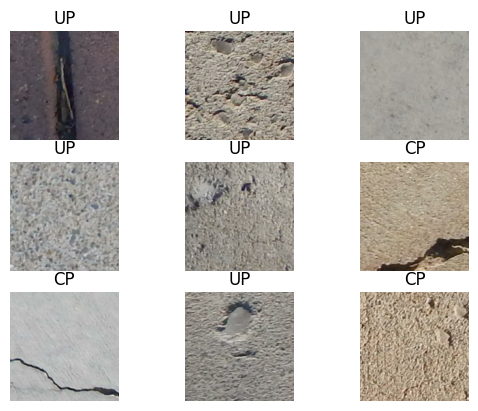

In [ ]:
#show the first nine images and labels

class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#now creating a test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset= validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 454
Number of test batches: 113


In [ ]:
#next up is configurations of the dataset for performance
#this will help prevent blocking

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#this is a large dataset, so we shouldn't be that worried about data augmentation
#however, it's a good practice to keep in mind
#the code below will be commented out but it's there as a reference
#for data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
#now let's create a base model using MobileNet V2

# Create the base model from the pre-trained model MobileNet V2


(from the transfer learning resource)

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


For feature extraction, you will need to freeze the convolutional base created from the previous step, then use as a feature extractor. Additionally, you'll add a classifier on top of it and train the top-level classifier.

It's important to freeze the convultional base before you compile and train the model. Freezing (by setting the layer.trainable=False) prevents the weights in a given layer from being updated during training

In [ ]:
base_model.trainable = False

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Next let's add a classification head.

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
#this is where you create the tensors! we basically convert pictures into tensors so the computer can 'see'
#so what's the difference between create vectors in NLP machine learning and tensors? Interesting you ask


#In fact tensors are merely a generalisation of scalars and vectors; a scalar is a zero rank tensor, and a vector is a first rank tensor.
#The rank (or order) of a tensor is defined by the number of directions (and hence the dimensionality of the array) required to describe it.
#so it's all related. A vector is a less complex tensor

#fun fact: a matrix is also a two-dimensional tensor. There's more to understand with this concept but it's best left
#to a math/physics course to explain that in more detail :p

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

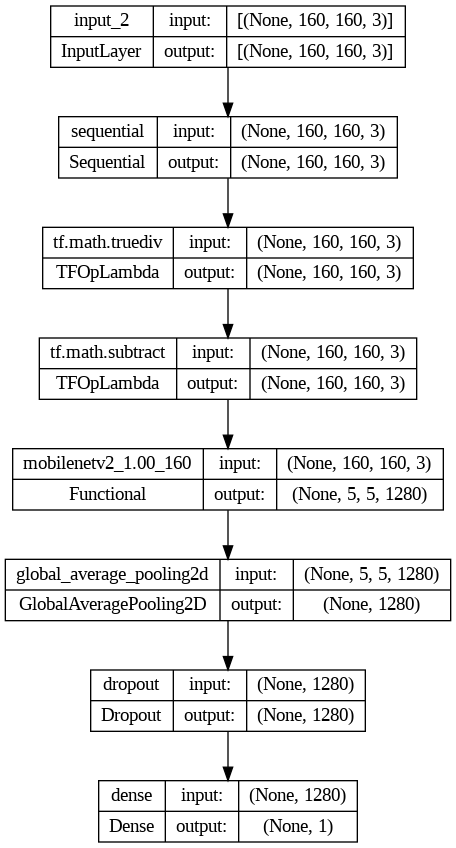

In [ ]:
#this nifty line of code creates your plot model!
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#neat, huh? now it's to compile the model before it can train


Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
#now let's train it!
#After training for 10 epochs, you should see ~96% accuracy on the validation set.

initial_epochs = 4

loss0, accuracy0 = model.evaluate(validation_dataset)

454/454 [==============================] - 312s 670ms/step - loss: 0.5493 - accuracy: 0.8263


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.32


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/4
761/761 [==============================] - 890s 1s/step - loss: 0.2255 - accuracy: 0.9264 - val_loss: 0.5437 - val_accuracy: 0.8304
Epoch 2/4
761/761 [==============================] - 878s 1s/step - loss: 0.2202 - accuracy: 0.9277 - val_loss: 0.5487 - val_accuracy: 0.8327
Epoch 3/4
761/761 [==============================] - 879s 1s/step - loss: 0.2171 - accuracy: 0.9294 - val_loss: 0.5462 - val_accuracy: 0.8347
Epoch 4/4
761/761 [==============================] - 879s 1s/step - loss: 0.2162 - accuracy: 0.9295 - val_loss: 0.5361 - val_accuracy: 0.8366


Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

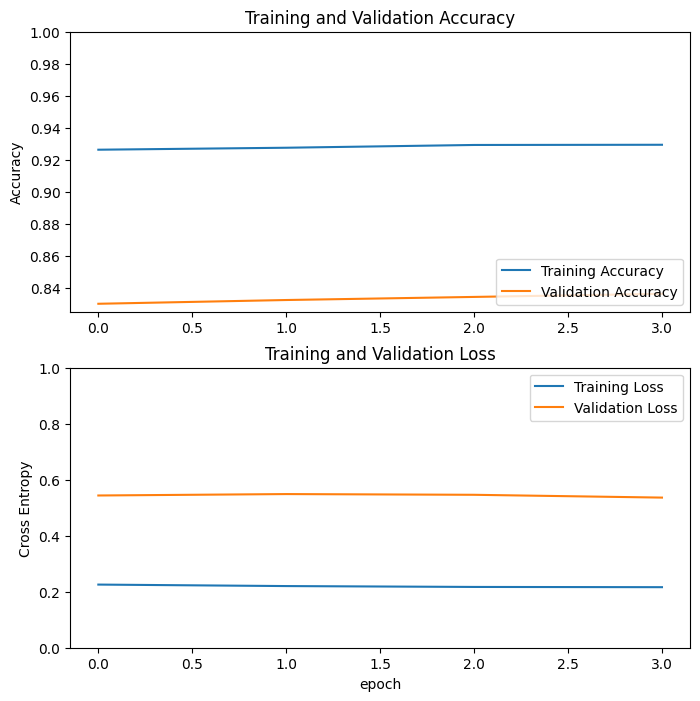

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

Now we move on to fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
#All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable.
#Then, you should recompile the model (necessary for these changes to take effect), and resume training.

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#next to compile it
#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a
# lower learning rate at this stage. Otherwise, your model could overfit very quickly.

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
#Then we continue training and adjusting
#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 4/6
761/761 [==============================] - 901s 1s/step - loss: 0.2137 - accuracy: 0.9299 - val_loss: 0.5281 - val_accuracy: 0.8376
Epoch 5/6
761/761 [==============================] - 906s 1s/step - loss: 0.2113 - accuracy: 0.9324 - val_loss: 0.5289 - val_accuracy: 0.8377
Epoch 6/6
761/761 [==============================] - 905s 1s/step - loss: 0.2120 - accuracy: 0.9317 - val_loss: 0.5305 - val_accuracy: 0.8374


In [ ]:
#After fine tuning the model nearly reaches 98% accuracy on the validation set.

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

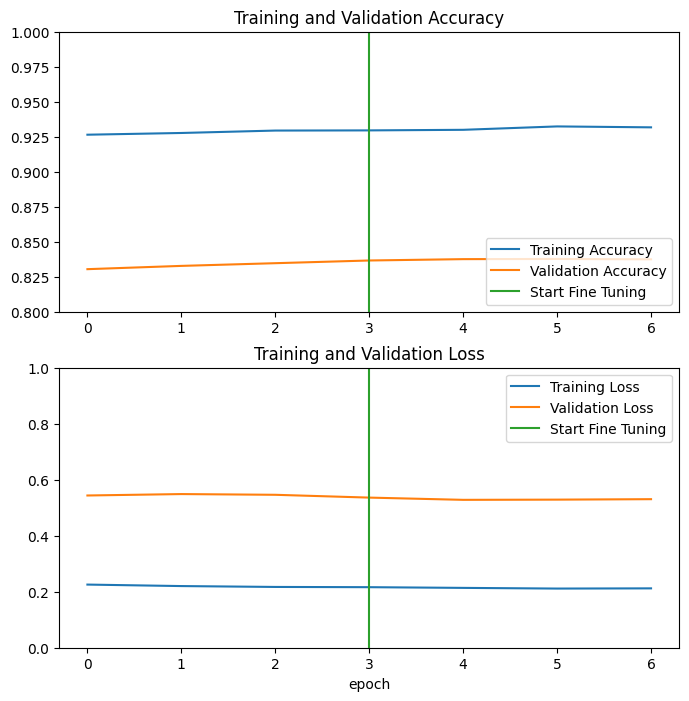

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Finally you can verify the performance of the model on new data using test set.
#So let's make some predictions!

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

113/113 [==============================] - 78s 680ms/step - loss: 0.5201 - accuracy: 0.8399
Test accuracy : 0.8398783206939697


Now let's see what this will do when it comes to predicting whether something is compromised or uncompromised

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


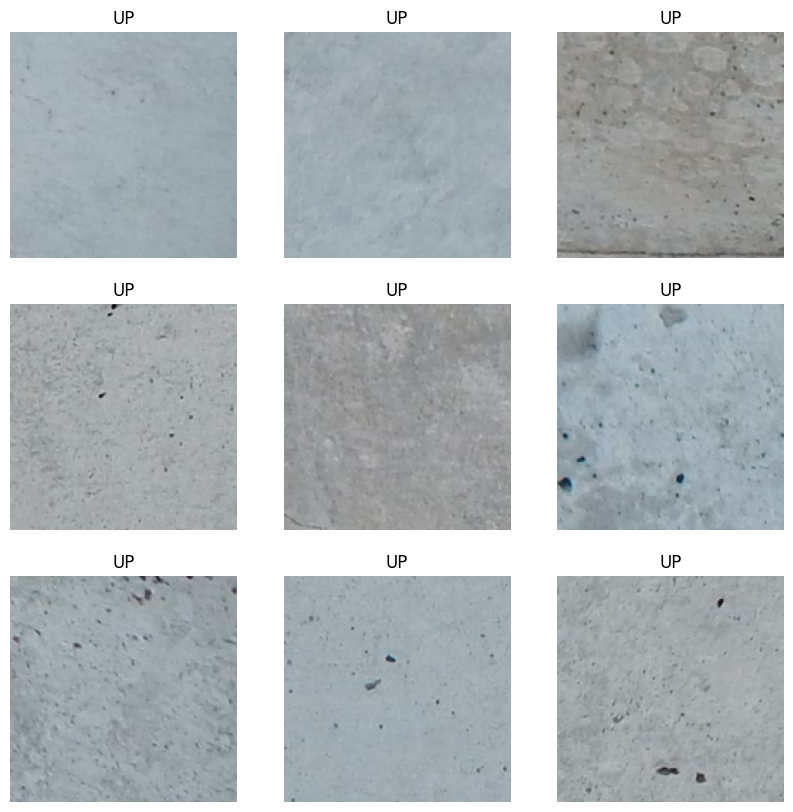

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")